In [101]:
import os
import site
import sqlite3
import sys
import warnings
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.api import SARIMAX, VAR, acf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from tqdm import tqdm
from yaml import dump, load, safe_load

In [102]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [103]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [104]:
sys.path.append("../../sql")
import queries

In [105]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [106]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [107]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['91708']


In [232]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time,
-- year, month, day, 
-- zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
-- Wind_Direction,
Wind_Speed
from nsrdb
where zipcode = :zipcode
-- and not (month = 2 and day = 29)
-- and year = 2000
;
"""


df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
columns = df.columns.tolist()
# df

In [236]:
df_rsm = df.resample("M").mean()

In [240]:
display(df_rsm.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 1998-01-31 to 2020-12-31
Freq: M
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Clearsky_DNI        276 non-null    float64
 1   DNI                 276 non-null    float64
 2   Clearsky_GHI        276 non-null    float64
 3   GHI                 276 non-null    float64
 4   Temperature         276 non-null    float64
 5   Relative_Humidity   276 non-null    float64
 6   Precipitable_Water  276 non-null    float64
 7   Wind_Speed          276 non-null    float64
dtypes: float64(8)
memory usage: 19.4 KB


None

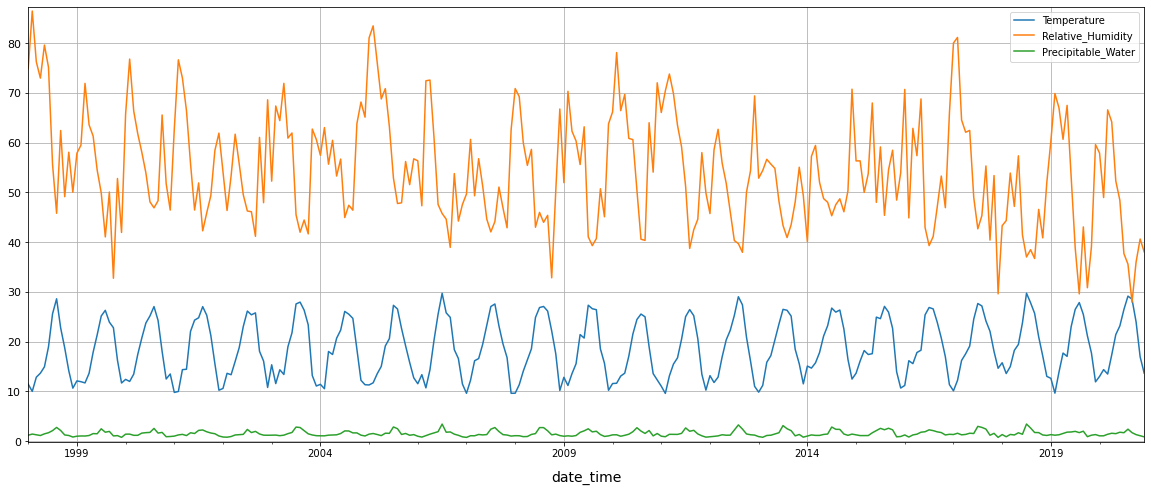

In [246]:
# # compares = ["Clearsky_DHI", "DHI"]

# compares = ["Wind_Speed", "Wind_Direction"]
compares = ["Temperature", "Relative_Humidity", "Precipitable_Water"]
# compares = ["Clearsky_GHI", "GHI"]
# compares = ["Clearsky_DNI", "DNI"]

compares_G = ["Clearsky_GHI", "GHI"]
compares_D = ["Clearsky_DNI", "DNI"]
compares_A = ["Temperature", "Relative_Humidity", "Precipitable_Water"]

df_rsm[compares].rolling(1).mean().plot(figsize=(20, 8))
# df_rsm[compares_G + compares_D].rolling(12).mean().plot(figsize=(20, 8))
plt.grid()

In [266]:
# df_diff = df_rsm.diff(periods=12).dropna()

df_diff = df_rsm.copy()
for column in columns:
    df_diff[column] = diff(df_diff[column], 1, 1, 12)

df_diff.dropna(inplace=True)

# df_diff.head(12)

In [267]:
adf_tests = []

for column in columns:
    adf_tests.append(adfuller(df_diff[column], autolag="AIC"))

for col, test in zip(columns, adf_tests):
    print(f"p-value: {test[1]} for {col}")

p-value: 5.172876851183793e-09 for Clearsky_DNI
p-value: 1.6690424186564485e-10 for DNI
p-value: 2.53847010895238e-09 for Clearsky_GHI
p-value: 4.835339506716251e-11 for GHI
p-value: 1.6361737605678158e-07 for Temperature
p-value: 2.3924221419536123e-10 for Relative_Humidity
p-value: 3.699476866649928e-12 for Precipitable_Water
p-value: 8.622377934789219e-10 for Wind_Speed


In [268]:
kpss_tests = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for column in columns:
        kpss_tests.append(kpss(df_diff[column], regression="ct", )) # nlags="auto"))

for column, test in zip(columns, kpss_tests):
    print(f"p-value: {test[1]}, {test[2]} for {column}")

p-value: 0.1, 16 for Clearsky_DNI
p-value: 0.1, 16 for DNI
p-value: 0.1, 16 for Clearsky_GHI
p-value: 0.1, 16 for GHI
p-value: 0.1, 16 for Temperature
p-value: 0.1, 16 for Relative_Humidity
p-value: 0.1, 16 for Precipitable_Water
p-value: 0.1, 16 for Wind_Speed


In [269]:
def plot_autocorr(df, features, max_lag):

    feat_count = len(features)

    if feat_count % 2 != 0:
        rows = int((feat_count + 1) / 2)
    else:
        rows = int(feat_count / 2)

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    fig, ax = plt.subplots(rows, 2, figsize=(20, 20))
    fig.tight_layout()
    ax = ax.flatten()

    for idx, feature in enumerate(features):
        plot_acf(
            df[feature],
            ax[idx],
            lags=max_lag,
            title=f"{feature} Autocorrelation",
        )
        ax[idx].set_xlabel(r"Lag")
        ax[idx].set_ylabel(r"Correlation")
        ax[idx].grid()
    plt.show();

In [270]:
def plot_part_autocorr(df, features, max_lag):

    feat_count = len(features)

    if feat_count % 2 != 0:
        rows = int((feat_count + 1) / 2)
    else:
        rows = int(feat_count / 2)

    fig, ax = plt.subplots(rows, 2, figsize=(20, 20))
    ax = ax.flatten()

    for idx, feature in enumerate(features):
        plot_pacf(
            df[feature],
            ax[idx],
            lags=max_lag,
            title=f"{feature} Partial Autocorrelation",
        )
        ax[idx].set_xlabel(r"Lag")
        ax[idx].set_ylabel(r"Partial Correlation")
        ax[idx].grid()

In [271]:
# plot_autocorr(df_rsm, columns, 36)

In [272]:
# plot_part_autocorr(df_rsm, columns, 36)

<Figure size 2160x1800 with 0 Axes>

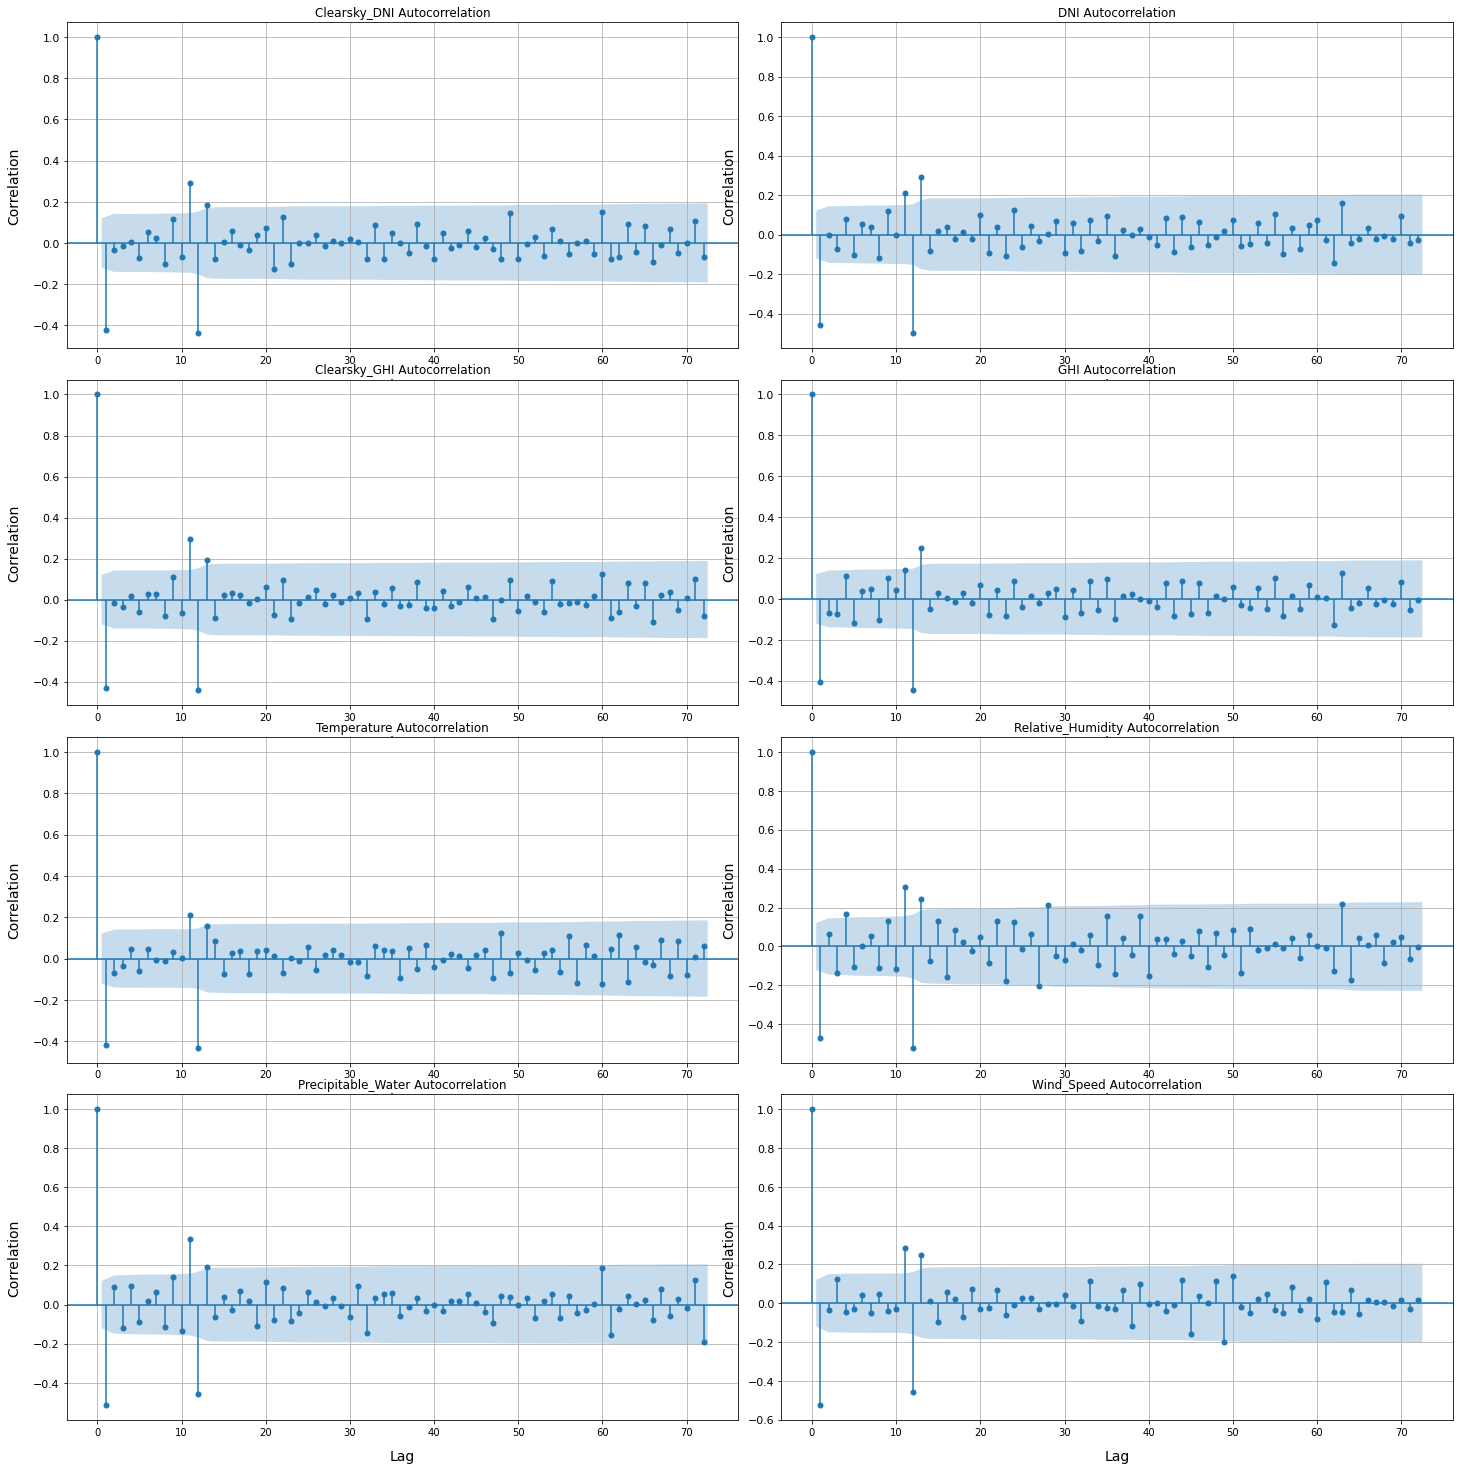

In [273]:
plot_autocorr(df_diff, columns, 72)

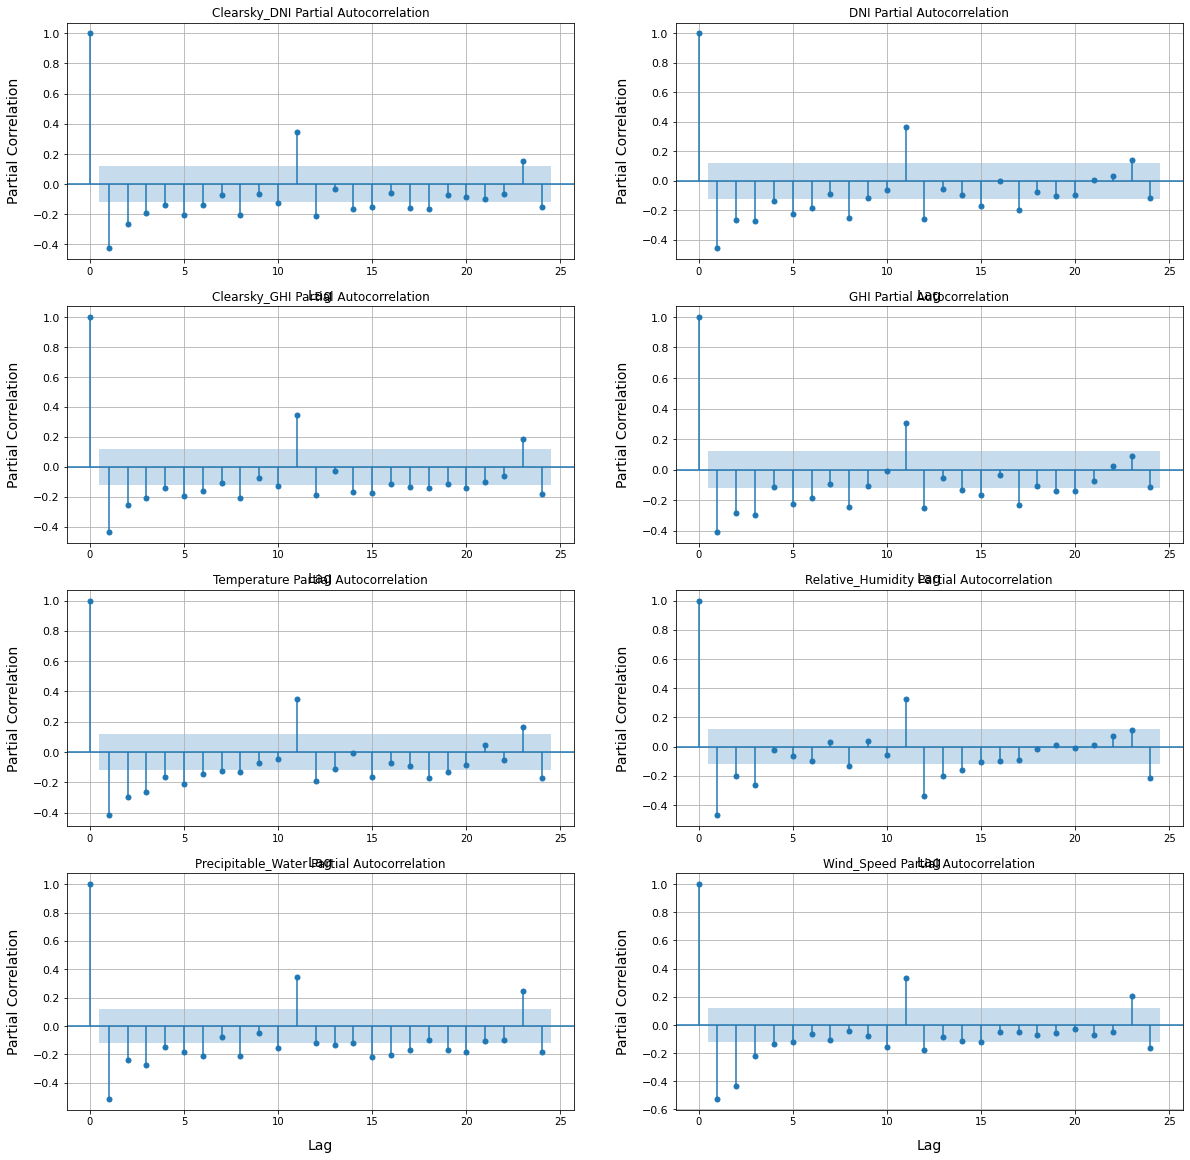

In [278]:
plot_part_autocorr(df_diff, columns, 24)

In [100]:
for x in range(1, 24):
    rho, sigma = yule_walker(df_rsm["GHI"], order=x, method="mle")
    print(f"rho: {-rho}\nsigma: {sigma}")

rho: [-0.82249391]
sigma: 42.657320843512565
rho: [-1.37560676  0.67248262]
sigma: 31.57123411779987
rho: [-1.01792873 -0.05917096  0.53187698]
sigma: 26.73520394661947
rho: [-0.83506283 -0.07951467  0.18190046  0.3438124 ]
sigma: 25.105381964197925
rho: [-0.68304817  0.00091157  0.14674352 -0.0254058   0.44214421]
sigma: 22.51812113692263
rho: [-0.59668236 -0.00405105  0.17540752 -0.02522774  0.30872165  0.19533404]
sigma: 22.084349419626058
rho: [-0.55533476  0.06129803  0.1700674   0.01190189  0.30786414  0.06903049
  0.21167635]
sigma: 21.583914081282305
rho: [-0.53238698  0.06878161  0.20344288  0.01319217  0.32630111  0.0756758
  0.15147264  0.10840976]
sigma: 21.45670484286296
rho: [-0.52716838  0.07607316  0.20708574  0.02889956  0.32693615  0.08546908
  0.15478363  0.08278186  0.04813773]
sigma: 21.431830243159116
rho: [-0.53119647  0.06914609  0.19413367  0.02174764  0.29957861  0.0830508
  0.137455    0.07641617  0.09225042 -0.08367854]
sigma: 21.35666453646374
rho: [-0.5214